In [41]:
import numpy as np
from data_preparation import *
from utils import *
import sys
import csv
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['KERAS_BACKEND'] = 'tensorflow'
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pandas as pd
from keras.layers import Input,Bidirectional,merge
from keras.layers.core import Dense, Activation, Dropout,Permute,Flatten
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers.convolutional import Conv1D,Conv2D
from keras.layers.pooling import MaxPooling1D,AveragePooling1D
from keras.models import load_model
from attention import AttentionLayer
from attention_with_context import AttentionWithContext
from keras.layers.wrappers import TimeDistributed
from keras.utils import CustomObjectScope
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

In [42]:
print('loading data...')
data1 = load_csv(r'basel_data', 6, "basel_data")
data2 = load_csv(r'basel_data', 2, "basel_data")
data3 = load_csv(r'basel_data', 3, "basel_data")
data4 = load_csv(r'basel_data', 4, "basel_data")
data5 = load_csv(r'basel_data', 5, "basel_data")
data6 = load_csv(r'basel_data', 1, "basel_data")

loading data...


In [43]:
day = 288
week = 2016
seq_len = 15
#1=5min, 3=15min, 6=30min, 12=60min
pre_len = 12
#data 1-7
pre_sens_num = 1

#train,test
train_data, train_w, train_d, label, test_data, test_w, test_d, test_l, test_med, test_min\
	= generate_data(data1, data2, data3, data4, data5, data6, seq_len, pre_len, pre_sens_num)

train_data = np.reshape(train_data,(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1))
train_w = np.reshape(train_w,(train_w.shape[0], train_w.shape[1], 1))
train_d = np.reshape(train_d,(train_d.shape[0], train_d.shape[1], 1))

test_data = np.reshape(test_data,(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1))
test_d = np.reshape(test_d,(test_d.shape[0], test_d.shape[1], 1))
test_w = np.reshape(test_w,(test_w.shape[0], test_w.shape[1], 1))

In [44]:
#load model
with CustomObjectScope({'AttentionLayer': AttentionLayer,'AttentionWithContext':AttentionWithContext}):
	json_file = open('model/conv_lstm.json', 'r')
	loaded_model_json = json_file.read()
	json_file.close()
	cnn_lstm_model = model_from_json(loaded_model_json)
	cnn_lstm_model.load_weights("model/model_0010-0.0001.h5", 'r')


NAME:  attention_with_context_1


(2016, 15, 6, 1) (2016, 15, 1) (2016, 15, 1)
predict_size: 2016


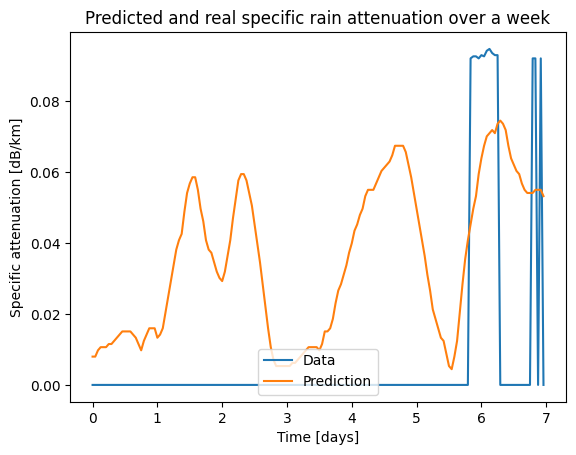

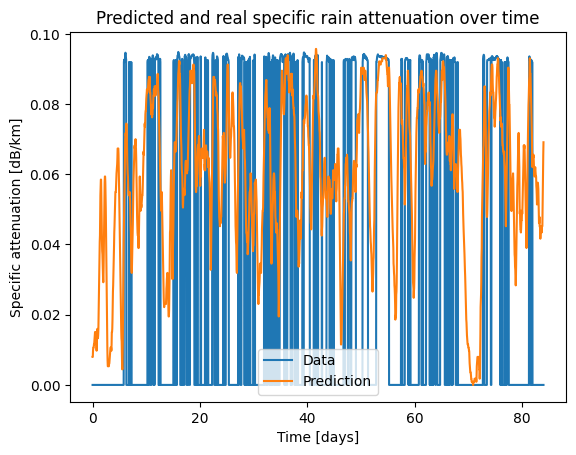

In [48]:
# start =time.clock()
print(test_data.shape,test_w.shape,test_d.shape)
predicted = predict_point_by_point(cnn_lstm_model, [test_data,test_w,test_d])
pred_med = (np.max(predicted) - np.min(predicted))
pred_min = np.min(predicted)

coefficient = -np.max(data1)/np.max(predicted - np.min(predicted))
scaled_prediction = - coefficient * (predicted  - np.min(predicted))
scaled_prediction = scaled_prediction - np.min(scaled_prediction)

x_axis = np.arange(0,len(scaled_prediction))/24

time_length = 7
start_index = -2032
plt.plot(x_axis[0:time_length*24],data1[start_index:start_index+time_length*24])
plt.plot(x_axis[0:time_length*24],scaled_prediction[0:time_length*24])
plt.legend(["Data", "Prediction"], loc='lower center')
plt.xlabel("Time [days]")
plt.ylabel("Specific attenuation [dB/km]")
plt.title("Predicted and real specific rain attenuation over a week")
plt.show()

plt.plot(x_axis,data1[-2032:-16])
plt.plot(x_axis,scaled_prediction)
plt.legend(["Data", "Prediction"], loc='lower center')
plt.xlabel("Time [days]")
plt.ylabel("Specific attenuation [dB/km]")
plt.title("Predicted and real specific rain attenuation over time")
plt.show()

In [49]:
MSE = np.sum((data1[start_index:start_index+time_length*24] - scaled_prediction[0:time_length*24])**2)/len(scaled_prediction[0:time_length*24])
MSE

0.0014916785106102455